###  二、DBSCAN 

这是一种基于密度的聚类算法，可以发现任意形状对的簇并能处理噪声数据

#### 1.基本概念

ε-邻域（Epsilon-neighborhood）：
对于某个点 p，以半径 ε 为边界的区域内所有的点称为该点的 ε-邻域。

核心点（Core Point）：
如果一个点 p 的 ε-邻域内至少有 minPts 个点（包括 p 自己），那么它被称为核心点。

边界点（Border Point）：
如果一个点 p 在某个核心点的 ε-邻域内，但自身不是核心点，它被称为边界点。

噪声点（Noise Point）：
如果一个点既不是核心点，也不属于任何核心点的邻域，它被认为是噪声点。

密度直达（Directly Density-Reachable）：
如果点 p 是核心点，并且点 q 在 p 的 ε-邻域内，那么 q 被称为从 p 密度直达。

密度可达（Density-Reachable）：
如果存在一条核心点链表（p1→p2→...→pn​），使得每个点从前一个点密度直达，且 p1=p，pn=q，则 q 是从 p 密度可达 的。

密度相连（Density-Connected）：
如果存在一个点 o，使得 p 和 q 都从 o 密度可达，则称 p 和 q 是密度相连的。

#### 2. 算法步骤

初始化：
从数据集中任意选择一个点 p，判断它是否为核心点（即 ε 邻域内是否包含至少 minPts 个点）。

扩展簇：
如果 p 是核心点，则开始一个新簇，将 p 及其邻域中的点加入簇中，并不断对新的核心点的邻域进行扩展。

处理噪声点：
如果一个点既不在任何簇中，也不满足成为核心点的条件，则将其标记为噪声点。

重复处理：
继续检查所有未访问的点，直到所有点都被访问为止。



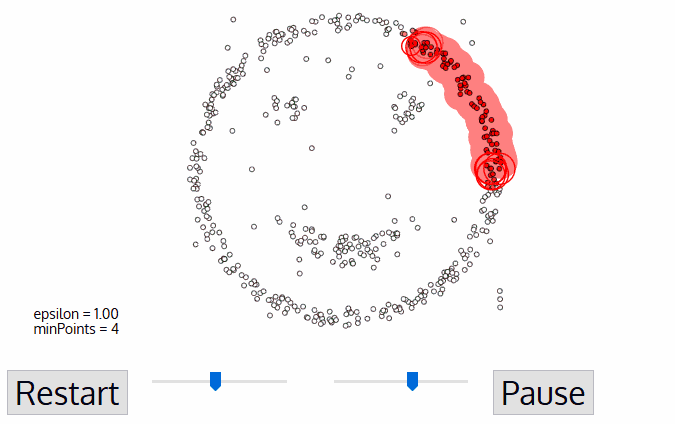

### 3.实战  
数据：sklearn自带的make_moons函数生成  
该数据集用于生成月牙形的聚类或分类数据    

数据由两个交错的 “月牙” 组成，属于非线性可分数据（无法用一条直线将两类数据完全分开）；  

可自定义样本数量、噪声大小，模拟真实场景中的数据扰动；  

生成的数据包含特征矩阵（X）和标签（y），标签只有 0/1 两类，分别对应两个月牙。

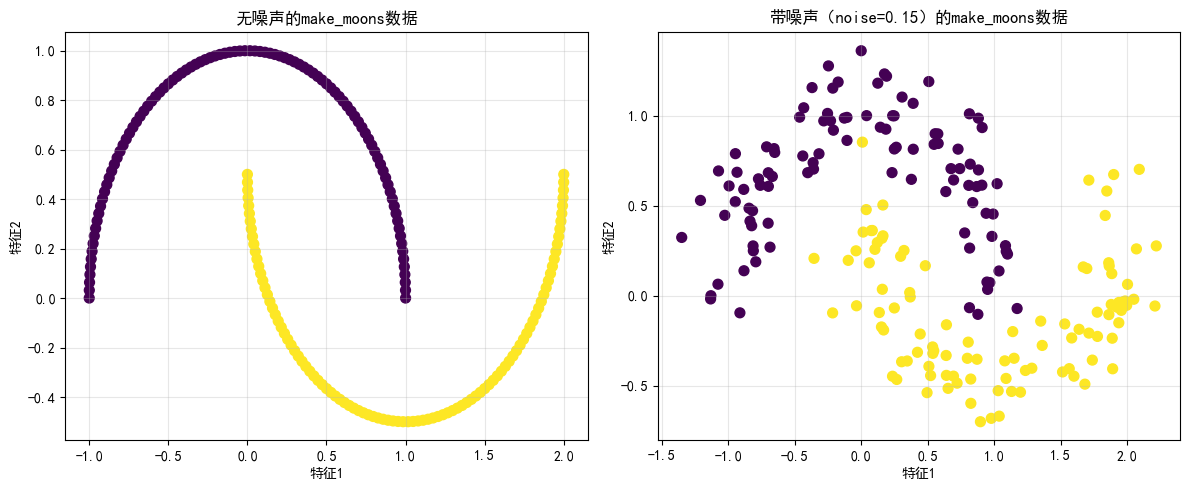

In [13]:
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['SimHei']
# 生成无噪声的月牙数据
X_no_noise, y_no_noise = make_moons(
    n_samples=200,
    noise=None,  # 无噪声，月牙边界清晰
    random_state=42
)

#  生成带噪声的月牙数据（更贴近真实场景）
X_with_noise, y_with_noise = make_moons(
    n_samples=200,
    noise=0.15,  # 加入适度噪声，数据略有重叠
    random_state=42
)

# 可视化对比（无噪声 vs 有噪声）
plt.rcParams['font.sans-serif'] = ['SimHei']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 无噪声数据
ax1.scatter(X_no_noise[:, 0], X_no_noise[:, 1], c=y_no_noise, cmap='viridis', s=50)
ax1.set_title('无噪声的make_moons数据', fontsize=12)
ax1.set_xlabel('特征1')
ax1.set_ylabel('特征2')
ax1.grid(alpha=0.3)

# 有噪声数据
ax2.scatter(X_with_noise[:, 0], X_with_noise[:, 1], c=y_with_noise, cmap='viridis', s=50)
ax2.set_title('带噪声（noise=0.15）的make_moons数据', fontsize=12)
ax2.set_xlabel('特征1')
ax2.set_ylabel('特征2')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['SimHei']
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from itertools import product

X, y_true = make_moons(
    n_samples=500,
    noise=0.15,  # 带适度噪声
    random_state=42
)

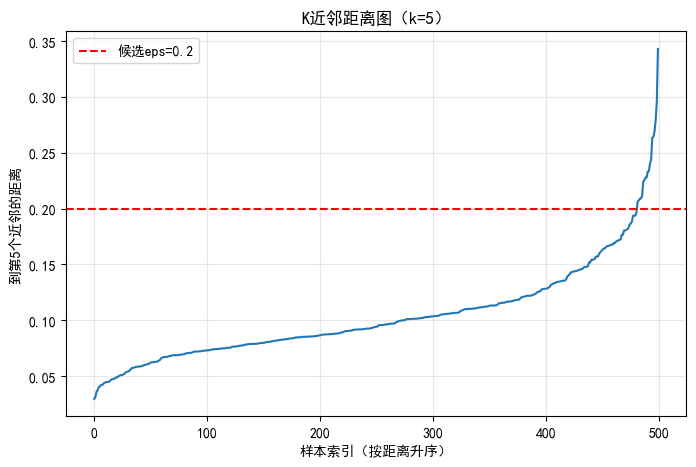

In [15]:
#用K近邻距离图确定eps的合理范围
k = 5  # k对应min_samples，先设为5（经验值：2*特征维度，这里特征维度=2）
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(X)
# 计算每个样本到第k个近邻的距离
distances, _ = neigh.kneighbors(X)
# 按距离升序排序
sorted_distances = np.sort(distances[:, k-1])

# 可视化K近邻距离图（找拐点）
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.figure(figsize=(8, 5))
plt.plot(sorted_distances)
plt.axhline(y=0.2, color='r', linestyle='--', label='候选eps=0.2')
plt.title(f'K近邻距离图（k={k}）', fontsize=12)
plt.xlabel('样本索引（按距离升序）')
plt.ylabel(f'到第{k}个近邻的距离')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [16]:
#超参数寻优
param_grid = {
    'eps': [0.15, 0.2, 0.25, 0.3],        # 围绕拐点0.2的候选值
    'min_samples': [3, 5, 7, 9]           # 核心点最小样本数候选
}
results_list = []


# 遍历所有参数组合
for eps, min_samples in product(param_grid['eps'], param_grid['min_samples']):
    # 训练DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    y_pred = dbscan.fit_predict(X)
    
    # 计算核心指标
    unique_labels = np.unique(y_pred)
    n_clusters = len(unique_labels[unique_labels != -1])
    n_noise = np.sum(y_pred == -1)
    noise_ratio = n_noise / len(X)
    
    # 计算评估指标（需至少2个有效聚类）
    sil_score = -1
    ch_score = 0
    if n_clusters >= 2:
        sil_score = silhouette_score(X, y_pred)
        ch_score = calinski_harabasz_score(X, y_pred)
    
    # 存储为元组，方便后续转结构化数组
    results_list.append((
        eps, min_samples, n_clusters,
        noise_ratio, sil_score, ch_score
    ))

results_arr = np.array(results_list, dtype=[
    ('eps', float), ('min_samples', int), ('n_clusters', int),
    ('noise_ratio', float), ('silhouette_score', float), ('ch_score', float)
])
sorted_results = np.sort(results_arr, order='silhouette_score')[::-1]

In [17]:
print("=== DBSCAN超参数寻优结果（按轮廓系数降序） ===")
print(f"{'eps':<6} {'min_samples':<12} {'聚类数':<8} {'噪声比例':<10} {'轮廓系数':<12} {'CH指数':<10}")
print("-" * 70)
for res in sorted_results:
    print(f"{res['eps']:<6.2f} {res['min_samples']:<12d} {res['n_clusters']:<8d} "
          f"{res['noise_ratio']:<10.2%} {res['silhouette_score']:<12.4f} {res['ch_score']:<10.2f}")

# 选择最优参数（轮廓系数最高）
best_idx = np.argmax(results_arr['silhouette_score'])
best_params = sorted_results[0]  # 排序后第一个就是最优
print(f"\n=== 最优参数组合 ===")
print(f"eps: {best_params['eps']:.2f}")
print(f"min_samples: {best_params['min_samples']}")
print(f"对应聚类数：{best_params['n_clusters']}，噪声比例：{best_params['noise_ratio']:.2%}")
print(f"轮廓系数：{best_params['silhouette_score']:.4f}")


=== DBSCAN超参数寻优结果（按轮廓系数降序） ===
eps    min_samples  聚类数      噪声比例       轮廓系数         CH指数      
----------------------------------------------------------------------
0.15   3            2        2.60%      0.2659       151.03    
0.15   7            2        7.40%      0.2479       132.11    
0.15   5            2        5.20%      0.2469       144.86    
0.15   9            3        11.80%     0.2166       158.55    
0.30   9            1        0.00%      -1.0000      0.00      
0.30   7            1        0.00%      -1.0000      0.00      
0.30   5            1        0.00%      -1.0000      0.00      
0.30   3            1        0.00%      -1.0000      0.00      
0.25   9            1        0.40%      -1.0000      0.00      
0.25   7            1        0.20%      -1.0000      0.00      
0.25   5            1        0.20%      -1.0000      0.00      
0.25   3            1        0.20%      -1.0000      0.00      
0.20   9            1        1.20%      -1.0000      0.00      
0.

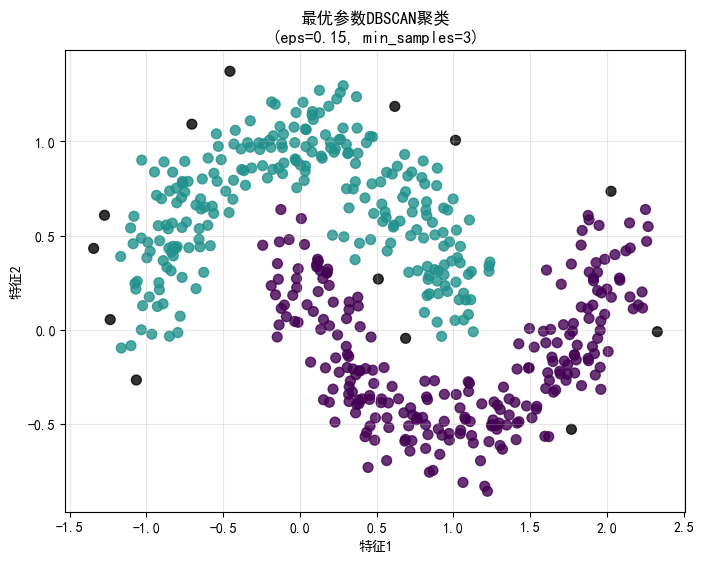

In [18]:
best_dbscan = DBSCAN(
    eps=best_params['eps'],
    min_samples=best_params['min_samples']
)
y_best = best_dbscan.fit_predict(X)

# 绘图
plt.figure(figsize=(8, 6))
# 噪声点标为黑色，聚类点用彩色
colors = plt.cm.viridis(y_best / best_params['n_clusters'])
colors[y_best == -1] = [0, 0, 0, 1]
plt.scatter(X[:, 0], X[:, 1], c=colors, s=50, alpha=0.8)
plt.title(
    f'最优参数DBSCAN聚类\n(eps={best_params["eps"]:.2f}, min_samples={best_params["min_samples"]})',
    fontsize=12
)
plt.xlabel('特征1')
plt.ylabel('特征2')
plt.grid(alpha=0.3)
plt.show()

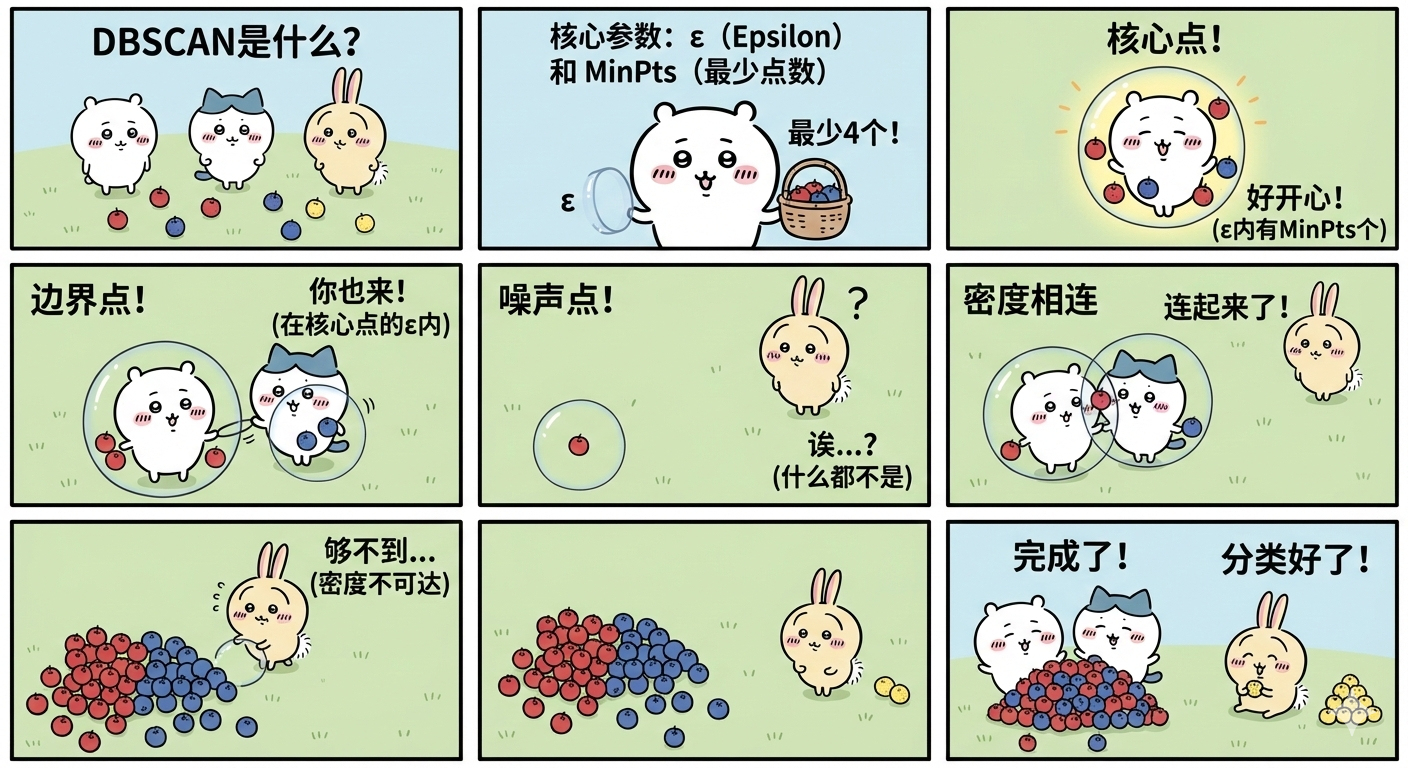

DBSCAN可以识别任何数量的任何形状的集群，对异常值较为稳健  
但如果集群之间的密度差异很大，或者如果某些集群周围没有足够低密度的区域，  
DBSCAN可能会无法正确捕获所有集群  
且DBSCAN无法用于较大数据集

参考文献：  
1）原文链接：https://blog.csdn.net/gotshgo/article/details/143231255